# Stock Cluster Analysis

### By Andrew Pickner

---

### Imports

1. **numpy**
    - Many extremely helpful mathematical methods
2. **pandas**
    - All of the data stored in DataFrames
3. **yfinance**
    - API that fetches a ton of financial and stock data
4. **datetime**
    - Needed to calculate the number of days between two dates for calculating the Sharpe Ratio
5. **matplotlib**
    - Crucial in order to visualize results graphically
6. **time**
    - Needed to sleep between data requests

In [1]:
import numpy             as np
import pandas            as pd
import yfinance          as yf
import datetime          as dt
import matplotlib.pyplot as plt
import time

---

### Global Variables 

1. **`INDEXES`**
    - Dictionary that holds major stock indexes 
        - Key: Index Name
        - Value: Index Symbol
    - **NOT FULLY IMPLEMENTED... Note:** Needs an initial dataset.
    - *kinda* went with what *seemed* to be a convention by saying 'indexes' rather than 'indices'
2. **`BENCHMARK`**
    - Choose the major index to run the program on
    - Current choices:
        - S&P 500
        - Dow Jones
        - NASDAQ
    - **NOT FULLY IMPLEMENTED... Note:** Needs an initial dataset.
3. **`BENCHMARK_SYMBOL`**
    - Get the symbol from **`INDEXES`** using the index name **`BENCHMARK`**
    - **NOT FULLY IMPLEMENTED... Note:** Needs an initial dataset.
4. **`PERIOD`**
    - This is the period of time we get price data for
        - Possible periods: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, td, max
5. **`SECTOR_COLOR_MAP`**
    - Maps each of the 11 sectors into a unique color
        - Useful for plotting each of the stocks colored by sector
6. **`CLUSTER_COLOR_MAP`**
    - Maps a number [0-10] into a unique color
        - Useful for plotting each of the stocks colored by cluster

In [2]:
##########################################################

INDEXES = {'S&P 500'  : '^GSPC',
           'Dow Jones': '^DJI',
           'NASDAQ'   : '^IXIC'
          } # 1

########################################################## 

BENCHMARK        = 'S&P 500' # 2
BENCHMARK_SYMBOL = INDEXES[BENCHMARK] # 3

########################################################## 

PERIOD = '1y' # 4

########################################################## 

SECTOR_COLOR_MAP  = {'Industrials'            : 'red', 
                     'Health Care'            : 'orange', 
                     'Information Technology' : 'yellow',
                     'Communication Services' : 'green', 
                     'Consumer Staples'       : 'blue', 
                     'Consumer Discretionary' : 'indigo',
                     'Utilities'              : 'violet', 
                     'Financials'             : 'pink', 
                     'Materials'              : 'cyan', 
                     'Real Estate'            : 'gray', 
                     'Energy'                 : 'brown'
                    } # 5

CLUSTER_COLOR_MAP = {0  : 'red', 
                     1  : 'orange', 
                     2  : 'yellow',
                     3  : 'green', 
                     4  : 'blue', 
                     5  : 'indigo',
                     6  : 'violet', 
                     7  : 'pink', 
                     8  : 'cyan', 
                     9  : 'gray', 
                     10 : 'brown'
                    } # 6

##########################################################

---

### Data Gathering and Exploration

Here, I am just getting all of the data I am planning on gathering. This list has certainly evolved over the course of the project.

For starters, I really wanted this 'program' to be able to work on any of the major stock indexes. It does, but it requires a CSV for the index of the form: `stock symbol`, `company name`, `sector`.

This is that initial dataset:

In [3]:
df = pd.read_csv('S&P500.csv')
df.head(3)

,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care


In [4]:
'''
Benchmark ticker object to get price data to test against
'''

benchmark = yf.Ticker(BENCHMARK_SYMBOL)

In [5]:
#################
# stock symbols #
#################
tickers = df.Symbol

###########
# sectors #
###########
sectors = df.Sector

In [6]:
'''
Downloads the historical price data for each stock and the benchmark
'''

#############
# benchmark #
#############

# Single download looks a little different
# https://pypi.org/project/yfinance/
benchmark_data = benchmark.history(period = PERIOD, auto_adjust = False, actions = False)

##########
# stocks #
##########

# Multi-stock download speeds things up quite well
# https://pypi.org/project/yfinance/
price_data = yf.download(
        tickers     = ' '.join(tickers),
        period      = PERIOD,
        interval    = '1d',
        group_by    = 'ticker',
        auto_adjust = False,
        prepost     = True,
        threads     = True
    )

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: None
- BRK.B: No data found, symbol may be delisted


In [7]:
'''
Parameters I will gather and/or compute
'''

# Any parameters that rely on the historical price data
price_parameters         = ['totalPriceChange', 'totalPercentChange', 'avgPriceChange', 'avgPercentChange']

# Any parameters that rely on the info data
info_parameters          = ['beta', 'pegRatio', 'forwardPE', 'trailingPE', 'currentRatio']

# Any parameters that rely on the financial data
financial_parameters     = ['Net Income', 'Total Revenue']

# Any parameters that rely on the balance sheet data
balancesheet_parameters  = ['Total Assets']

# Any other parameters 
other_parameters         = ['sharpeRatio', 'ROA', 'assetTurnover']

# All the parameters we are collecting
parameters = price_parameters + info_parameters + financial_parameters + balancesheet_parameters + other_parameters

all_columns  = ['Symbol'] + parameters + ['Sector']
use_columns  = ['ROA', 'assetTurnover']

In [72]:
# Computes the total change in price
def totalPriceChange(price_data):
    rows, cols   = price_data.shape
    price_change = price_data.iloc[rows - 1]['Close'] - price_data.iloc[0]['Open']
    return np.round(price_change, 2)

# Computes the total change in price as a percent
def totalPercentChange(price_data):
    rows, cols     = price_data.shape
    original       = price_data.iloc[0]['Open']
    price_change   = price_data.iloc[rows - 1]['Close'] - original
    percent_change = price_change / original
    return np.round(percent_change, 2)

# Computes the average change in price
def avgPriceChange(price_data):
    return np.round(np.mean(price_data['Close'].diff()), 2)

# Computes the average change in price as a percent
def avgPercentChange(price_data):
    return np.round(np.mean(price_data['Close'].pct_change()), 4)

# Computes the total change in price FOR MULTIPLE STOCKS AT ONCE
def totalPriceChangeForMultipleStocks(price_data, tickers):
    opens      = []
    closes     = []
    rows, cols = price_data[tickers[0]].shape
    for ticker in tickers:
        opens.append(price_data[ticker].iloc[0]['Open'])
        closes.append(price_data[ticker].iloc[rows - 1]['Close'])
    price_change   = np.sum(closes) - np.sum(opens)
    return np.round(price_change, 2)

# Computes the total change in price as a percent FOR MULTIPLE STOCKS AT ONCE
def totalPercentChangeForMultipleStocks(price_data, tickers):
    opens      = []
    closes     = []
    rows, cols = price_data[tickers[0]].shape
    for ticker in tickers:
        opens.append(price_data[ticker].iloc[0]['Open'])
        closes.append(price_data[ticker].iloc[rows - 1]['Close'])
    price_change   = np.sum(closes) - np.sum(opens)
    percent_change = price_change / np.sum(opens)
    return np.round(percent_change, 2)
    
price_functions = [totalPriceChange, totalPercentChange, avgPriceChange, avgPercentChange]

In [9]:
# https://scholarship.claremont.edu/cgi/viewcontent.cgi?article=3517&context=cmc_theses
# https://www.investopedia.com/terms/s/sharperatio.asp
def sharpeRatio(price_data, risk_free_rate = 0):
    date_str   = '%Y-%m-%d %H:%M:%S'
    log_return = np.log(price_data['Close'] / price_data['Close'].shift())
    sr         = (np.mean(log_return) - risk_free_rate) / np.std(log_return)
    start_date = dt.datetime.strptime(str(price_data.index[0]), date_str)
    end_date   = dt.datetime.strptime(str(price_data.index[-1]), date_str)
    length     = (end_date - start_date).days
    return sr * np.sqrt(length) 

def ROA(income, assets):
    i, a           =  income, assets
    i_flag, a_flag = False, False
    if (i == None) or (i == np.nan):
        i_flag = True
    if (a == None) or (a == np.nan) or (a == 0):
        a_flag = True
    if i_flag:
        return i
    elif a_flag:
        return a 
    else:
        return i / a

def assetTurnover(revenue, assets):
    r, a           =  revenue, assets
    r_flag, a_flag = False, False
    if (r == None) or (r == np.nan):
        r_flag = True
    if (a == None) or (a == np.nan) or (a == 0):
        a_flag = True
    if r_flag:
        return r
    elif a_flag:
        return a 
    else:
        return r / a

other_functions = [sharpeRatio, ROA, assetTurnover]

---

### Returns the list of the specific parameter values

- price
- info
- financial
- balancesheet

In [10]:
def get_price_values(price_data, functions, fill_val = np.nan):
    l = []
    for f in functions:
        try:
            l.append(f(price_data))
        except:
            l.append(fill_val)
    return l

In [11]:
def get_info_values(info, info_params, fill_val = None):
    l    = []
    for item in info_params:
        try:
            l.append(info[item])
        except:
            l.append(fill_val)
    return l

In [12]:
def get_financial_values(financials, financial_params, fill_val = None):
    l          = []
    for item in financial_params:
        try:
            l.append(financials.loc[item, financials.columns[0]])
        except:
            l.append(fill_val)
    return l

In [13]:
def get_balancesheet_values(balance_sheet, balancesheet_params, fill_val = None):
    l             = []
    for item in balancesheet_params:
        try:
            l.append(balance_sheet.loc[item, balance_sheet.columns[0]])
        except:
            l.append(fill_val)
    return l

In [15]:
data = pd.DataFrame(columns = all_columns)

n = int(len(tickers) / 25)
for i, ticker in enumerate(tickers):
    if i % n == 0:
        time.sleep(30)
    
    print(f'{i + 1}/{len(tickers)} - {ticker}')
    
    p_data       = price_data[ticker]
    t            = yf.Ticker(ticker)
    
    i_data       = t.info
    f_data       = t.financials
    b_data       = t.balance_sheet
    
    price        = get_price_values(p_data, price_functions)
    info         = get_info_values(i_data, info_parameters)
    financials   = get_financial_values(f_data, financial_parameters)
    balancesheet = get_balancesheet_values(b_data, balancesheet_parameters)
    
    other_args   = {0: [p_data], 1: [financials[0], balancesheet[0]], 2: [financials[1], balancesheet[0]]}
    other        = [f(*other_args[i]) for i, f in enumerate(other_functions)]
    
    l            = [ticker] + price + info + financials + balancesheet + other + [sectors[i]]
    d            = {col: l[i] for i, col in enumerate(all_columns)}
    
    data = data.append(d, ignore_index = True)   
    
data.head()

1/506 - MMM
2/506 - AOS
3/506 - ABT
4/506 - ABBV
5/506 - ABMD
6/506 - ACN
7/506 - ATVI
8/506 - ADM
9/506 - ADBE
10/506 - AAP
11/506 - AMD
12/506 - AES
13/506 - AFL
14/506 - A
15/506 - APD
16/506 - AKAM
17/506 - ALK
18/506 - ALB
19/506 - ARE
20/506 - ALGN
21/506 - ALLE
22/506 - LNT
23/506 - ALL
24/506 - GOOGL
25/506 - GOOG
26/506 - MO
27/506 - AMZN
28/506 - AMCR
29/506 - AEE
30/506 - AAL
31/506 - AEP
32/506 - AXP
33/506 - AIG
34/506 - AMT
35/506 - AWK
36/506 - AMP
37/506 - ABC
38/506 - AME
39/506 - AMGN
40/506 - APH
41/506 - ADI
42/506 - ANSS
43/506 - ANTM
44/506 - AON
45/506 - APA
46/506 - AAPL
47/506 - AMAT
48/506 - APTV
49/506 - ANET
50/506 - AJG
51/506 - AIZ
52/506 - T
53/506 - ATO
54/506 - ADSK
55/506 - ADP
56/506 - AZO
57/506 - AVB
58/506 - AVY
59/506 - BKR
60/506 - BLL
61/506 - BAC
62/506 - BBWI
63/506 - BAX
64/506 - BDX
65/506 - BRK.B
66/506 - BBY
67/506 - BIO
68/506 - TECH
69/506 - BIIB
70/506 - BLK
71/506 - BK
72/506 - BA
73/506 - BKNG
74/506 - BWA
75/506 - BXP
76/506 - BSX
77

,Symbol,totalPriceChange,totalPercentChange,avgPriceChange,avgPercentChange,beta,pegRatio,forwardPE,trailingPE,currentRatio,Net Income,Total Revenue,Total Assets,sharpeRatio,ROA,assetTurnover,Sector
0,MMM,1.20,0.01,0.01,0.0001,0.953056,2.22,16.543,17.9278,1.705,5.384e+09,3.2184e+10,4.7344e+10,0.090443,0.113721,0.67979,Industrials
1,AOS,26.74,0.48,0.11,0.0016,1.12571,3.58,23.6686,28.4187,1.769,3.449e+08,2.8953e+09,3.1607e+09,1.781178,0.109121,0.916031,Industrials
2,ABT,26.96,0.25,0.11,0.0010,0.685714,2.02,28.1053,33.1266,1.826,4.495e+09,3.4608e+10,7.2548e+10,1.291965,0.061959,0.477036,Health Care
3,ABBV,24.67,0.23,0.09,0.0010,0.788051,2.24,9.28673,31.0296,1.015,4.616e+09,4.5804e+10,1.50565e+11,1.198404,0.0306579,0.304214,Health Care
4,ABMD,43.99,0.17,0.12,0.0007,1.27065,7.31,61.6171,95.3485,7.643,2.25525e+08,8.47522e+08,1.49436e+09,0.385298,0.150918,0.567148,Health Care


---

### Cleaning the Dataset

Here, I remove any rows that have null values in the columns that we are going to use to cluster.

In [28]:
# Set of all tickers initially
s1 = set(tickers)

# Removes any rows with no values in 
cleaned_data = data.dropna(subset=use_columns)

# Set of tickers after we drop the necessary rows
s2 = set(cleaned_data.Symbol)

# Set of tickers that were removed
removed_symbols = s1 - s2

print(f'Removed {len(removed_symbols)} stocks.')
print(f'They are: {removed_symbols}')

Removed 6 stocks.
They are: {'BRK.B', 'UDR', 'PWR', 'ODFL', 'RJF', 'BF.B'}


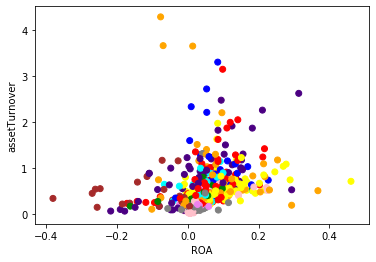

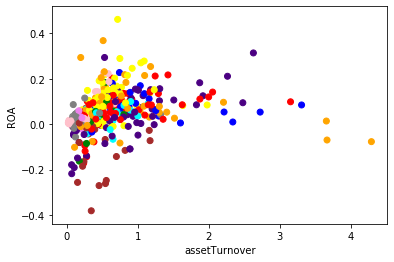

In [29]:
colors = [SECTOR_COLOR_MAP[sector] for sector in dropna_data['Sector']]

for col1 in use_columns:
    for col2 in use_columns:
        if col1 != col2:
            x = dropna_data[col1]
            y = dropna_data[col2]
            plt.figure()
            plt.scatter(x, y, c = colors)
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.show()

---

### K-means

This is the code I wrote for HW3. Overall pretty satisfied with it because it is pretty portable and worked right away with this dataset.

I think all of this code is commented pretty well, so I'll be brief here.

#### Point

A simple n-dimensional point object with a method for computing euclidean distance 

#### Cluster

A simple cluster object with methods for computing a centroid and the average distance to that centroid

#### kMeans_Clustering

This is the actual clustering algorithm! 

In [30]:
#######################################################################################################
# Simple n-dimensional point object
#######################################################################################################
class Point:
    '''
    INPUT:
        c:           list or tuple of coordinates that represent a point with n-dimensions
    ----------------------------------------------------------------------------------------
    SELF:
        coordinates: converted tuple of the list/tuple that is inputted as c
        n:           number of dimensions calculated by taking the length of c
    '''
    def __init__(self, c):
        self.coordinates = tuple(c)
        self.n           = len(c)
    
    def __repr__(self):
        temp = ''.join(["{:.2f}, ".format(self.coordinates[i]) for i in range(self.n - 1)])
        s = "(" + temp + "{:.2f})".format(self.coordinates[-1])
        return s
    
    def euclidean_distance(self, p2):
        return np.linalg.norm(np.array(self.coordinates) - np.array(p2.coordinates))
        '''return np.sqrt(np.sum([(self.coordinates[i] - p2.coordinates[i]) ** 2 for i in range(self.n)]))'''
    
#######################################################################################################
# Cluster Object
#######################################################################################################
class Cluster:
    '''
    INPUT:
        points:   Can accept a list of points for initialization, default is an empty list
        
        It's funny, I actually had this from the get-go but I was too stubborn to use it in 
        kMeans ultimately causing a major slowdown.
    ----------------------------------------------------------------------------------------
    SELF:
        points:   List of Point objects of the given Cluster Object
        centroid: The centroid of the given Cluster given the list of Point objects
        avg_dist: The average distance each Point is to the centroid in the given Cluster
        index:    The number used for returning a color list at the end
        n:        Number of dimensions calculated by taking the dimension from the given Point object 
    '''
    def __init__(self, points=[]):
        self.points     = []
        self.centroid   = None
        self.avg_dist   = None
        self.index      = None
        self.n          = None
        if len(points) > 0:
            self.points = points
            self.n      = self.points[0].n
            self.compute_centroid()
            self.compute_avg_distance()
    
    # Printing purposes
    def __repr__(self):
        return "Index: {}\nCentroid: {}\nAvg. Distance: {:.2f}\nPoints: {}\nNumber of Points: {}\n".format(self.index, self.centroid, self.avg_dist, self.points, len(self.points))
    
    # Returns the list of points in a given cluster
    def get_points(self):
        return self.points

    # Sets the index of a cluster for coloring purposes
    def set_index(self, i):
        self.index = i
    
    # Adds a point to the list of points and computes the new centroid of the cluster
    # and the average distance of each point from the cluster
    def add_point(self, point):
        self.points.append(point)
        if len(self.points) == 1:
            self.centroid = point
            self.avg_dist = 0.0
            self.n        = point.n
        else:
            # This is where my slow speed was coming from.
            # Mostly the compute_avg_distance, I should make an update function for this. 
            self.update_centroid()
            self.compute_avg_distance()

    # Adds a list of points to the given list of points, and computes 
    # the new centroid of the cluster and the average distance of each point from the cluster
    def add_points(self, points):
        self.points.extend(points)
        if len(self.points) == 1:
            self.centroid = points[0]
            self.avg_dist = 0.0
            self.n        = points[0].n
        else:
            self.compute_centroid()
            self.compute_avg_distance()
    
    # Added this for kMeans so I could add initial centroids without adding a 
    # point to the cluster
    def add_centroid(self, point):
        if len(self.points) == 0: 
            self.centroid = point
            self.avg_dist = 0.0
            self.n        = point.n
    
    # This function is kinda necessary for removing points
    def compute_centroid(self):
        means = [np.mean([pt.coordinates[i] for pt in self.points]) for i in range(self.n)]
        self.centroid = Point(means)
    
    # Updates the centroid, less computationally expensive then 
    # computing it from scratch
    def update_centroid(self):
        len_pts       = len(self.points)
        old           = [self.centroid.coordinates[i] for i in range(self.n)]
        new           = [self.points[-1].coordinates[i] for i in range(self.n)]
        update        = [(old[i] + ((new[i] - old[i]) / len_pts)) for i in range(self.n)]
        self.centroid = Point(update)
    
    # Computes the average distance of each point to the centroid
    def compute_avg_distance(self):
        distances = []
        for point in self.points:
            distances.append(self.centroid.euclidean_distance(point))
        self.avg_dist = np.mean(distances)
    
    # Removes a point if it is present in the list of points
    def remove_point(self, point):
        try:
            self.points.remove(point)
            self.compute_centroid()
            self.compute_avg_distance()
        except ValueError:
            return

#######################################################################################################
# K Means CLustering Object
#######################################################################################################
class kMeans_Clustering:
    '''
    INPUT:
        points:           Needs a list of points to cluster on, wants the Point objects I created above
        k:                Needs a number of clusters to cluster the points into  
        init_points:      Can input a list of initial Point objects as initial clusters. Only takes up to
                          k initial points. Default is empty list, and will randomly select a point and then 
                          furthest points subsequently.
        random:           If random is set to True, all the points are picked randomly. Default is False.
        convergence_term: Can input a convergence term to change when the algorithm terminates. 
                          Currently, the algorithm sums the distance in centroids as they change so
                          it is best to be less than 1. Default is 1e-10.
    ----------------------------------------------------------------------------------------
    SELF:
        points:   The inputted list of Point objects
        k:        The inputted number of clusters to end on
        clusters: The list of Cluster objects
    '''
    def __init__(self, points, k, init_points=[], random=False, convergence_term=1e-10):
        self.points     = points
        self.k          = k
        self.clusters   = []
        self.convergence_term = convergence_term
        i = 0
        for pt in init_points:
            if i < k:
                c = Cluster()
                c.add_centroid(pt)
                self.clusters.append(c)
            i += 0
        furthest_points = k - len(self.clusters)
        if random:
            pts = np.random.choice(self.points, furthest_points, False)
            for pt in pts:
                c = Cluster()
                c.add_centroid(pt)
                self.clusters.append(c)
            furthest_points -= furthest_points
        if furthest_points == k:
            pt = np.random.choice(self.points)
            c = Cluster()
            c.add_centroid(pt)
            self.clusters.append(c)
            furthest_points -= 1
        if furthest_points != 0: 
            for i in range(furthest_points):
                dist = []
                for pt in self.points:
                    dist.append(np.sum([pt.euclidean_distance(init_points[i]) for i in range(len(init_points))]))
                c = Cluster()
                c.add_centroid(self.points[dist.index(np.max(dist))])
                self.clusters.append(c)  

    # Returns all points                             
    def get_points(self):
        return self.points
    
    # Performs K Means clustering, and returns the clusters of the given points
    # the centroids of the clusters, and the average distance from all points 
    # in a cluster to its centroid
    def Perform_kMeans(self, print_clusters=True):
        # have to flip the names here to get it to work
        new_centroids = self.get_cluster_centroids()
        old_centroids = self.initialize_new_centroids()
        c_distance = np.sum([old_centroids[i].euclidean_distance(new_centroids[i]) for i in range(len(old_centroids))])

        convergence = False if c_distance >= self.convergence_term else True
        
        points       = self.get_points()
        point_matrix = np.matrix([p.coordinates for p in points])
        num_points   = len(points)
        
        while (not convergence):
            centroid_matrix = np.matrix([centroid.coordinates for centroid in new_centroids])
            distances = [[np.linalg.norm(point_matrix[j] - centroid_matrix[i]) for i in range(self.k)] for j in range(num_points)]
            indices = [distance.index(min(distance)) for distance in distances]

            d = {i: [] for i in range(self.k)}
            for i in range(num_points):
                d[indices[i]].append(points[i])
            
            for i in range(self.k):
                self.clusters[i].add_points(d[i])
                

            old_centroids = new_centroids
            new_centroids = self.get_cluster_centroids()
            c_distance = np.sum([old_centroids[i].euclidean_distance(new_centroids[i]) for i in range(self.k)])
            
            convergence = False if c_distance >= self.convergence_term else True
            
            if not convergence:
                self.clusters = []
                for centroid in new_centroids:
                    c = Cluster()
                    c.add_centroid(centroid)
                    self.clusters.append(c)
  

        self.print_clusters(print_clusters)
            
        cluster_indices = self.get_cluster_colors()
        centroids = [self.clusters[i].centroid for i in range(len(self.clusters))]
        avg_distances = [self.clusters[i].avg_dist for i in range(len(self.clusters))]
        return cluster_indices, centroids, avg_distances
    
    # List comprehension to get the cluster centroids in a list
    def get_cluster_centroids(self):
        return [Point([cluster.centroid.coordinates[i] for i in range(cluster.n)]) for cluster in self.clusters]
    
    # List comprehension to initialize necessary number of centroids to 0 (zero)
    def initialize_new_centroids(self):
        return [Point([0 for i in range(cluster.n)]) for cluster in self.clusters]
    
    # prints the clusters if the flag is set to True in Perform_kMeans
    # flag is set to true as default
    def print_clusters(self, print_clusters):
        i = 0
        for cluster in self.clusters:
            cluster.set_index(i)
            if print_clusters:
                print(cluster)
            i += 1
    
    # Gets the colors / indices of each cluster for the points.
    # Also sets the indices of the cluster objects
    def get_cluster_colors(self):
        cluster_indices = np.zeros(len(self.points))
        for cluster in self.clusters:
            for point in cluster.get_points():
                cluster_indices[self.points.index(point)] = cluster.index
        return cluster_indices

---

### Turning the data into Point objects

In [31]:
rows, cols = cleaned_data.shape[0], len(use_columns)
X = np.zeros((rows, cols))

for i, column in enumerate(use_columns):
    X[:,i] = cleaned_data[column]

pts = [Point(x) for x in X]

---

### Elbow Plot

Finding which values of $k$ are viable.

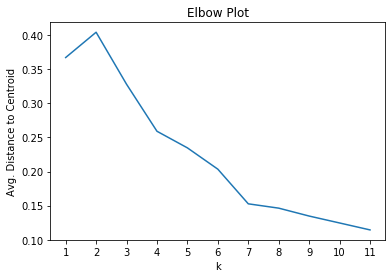

In [32]:
min_k, max_k  = 1, 11

avg_distances = []
ks            = []
for k in range(min_k, max_k + 1):
    kM_C = kMeans_Clustering(pts, k, random=True)
    cluster_colors, centroids, avg_distance = kM_C.Perform_kMeans(False)

    avg_distances.append(np.mean(avg_distance))
    ks.append(k)
    
plt.plot(ks, avg_distances)
plt.xticks(ks)
plt.title('Elbow Plot')
plt.xlabel('k')
plt.ylabel('Avg. Distance to Centroid')
plt.savefig('Elbow Plot.png')

In [33]:
k_values = [4, 7]

From the plot, it appears that we have $k=4$ and $k=7$ where the slope of the plot flattens out the most.

---

---

### Clustering

I cluster with the k-values found from our elbow plot. It would be nice to programmitically select these, but for now, eyeballing them is fine.

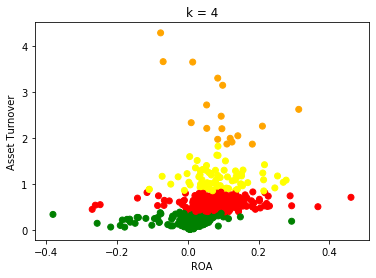

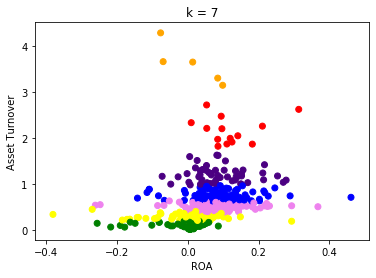

In [76]:
clusters = []
for k in k_values:
    kM_C = kMeans_Clustering(pts, k, random=True)
    cluster_colors, centroids, avg_distances = kM_C.Perform_kMeans(False)
    clusters.append(cluster_colors)
    colors = [CLUSTER_COLOR_MAP[i] for i in cluster_colors]
    plt.scatter(X[:,0], X[:,1], c=colors)
    plt.title(f'k = {k}')
    plt.xlabel('ROA')
    plt.ylabel('Asset Turnover')
    plt.savefig(f'{k}-cluster.png')
    plt.show()

---

### Establishing a Benchmark

I am trying to develop portfolios that beat or perfrom alongside the chosen stock index

In [17]:
print(f'{BENCHMARK}: {PERIOD}\n')

benchmark_total_price_change   = totalPriceChange(benchmark_data)
benchmark_total_percent_change = totalPercentChange(benchmark_data)
benchmark_avg_price_change     = avgPriceChange(benchmark_data)
benchmark_avg_percent_change   = avgPercentChange(benchmark_data)

print(f'\tTotal price change     = ${benchmark_total_price_change}')
print(f'\tTotal percent change   = {benchmark_total_percent_change * 100}%')
print(f'\t--------------------------------')
print(f'\tAverage price change   = ${benchmark_avg_price_change}')
print(f'\tAverage percent change = {benchmark_avg_percent_change * 100}%')

S&P 500: 1y
	Total price change     = $958.22
	Total percent change   = 26.0%
	--------------------------------
	Average price change   = $3.72
	Average percent change = 0.09%


---

### The actual stock portfolios!

These are the portfolios of stocks tht I've developed from clustering the entire dataset.

In [73]:
cluster_columns = {'Symbol': cleaned_data.Symbol, 'sharpeRatio': cleaned_data.sharpeRatio}

cluster_dfs     = []
portfolios      = []
return_amounts  = []
return_percents = []

for cluster in clusters:
    cluster_df = pd.DataFrame(cluster_columns)
    cluster_df['clusterIndex'] = cluster
    cluster_dfs.append(cluster_df)

for df in cluster_dfs:
    portfolio = []
    min_v     = int(np.min(df['clusterIndex']))
    max_v     = int(np.max(df['clusterIndex']))
    for i in range(min_v, max_v + 1):
        temp      = df[df['clusterIndex'] == i]
        max_score = np.max(temp['sharpeRatio'])
        max_item  = temp[temp['sharpeRatio'] == max_score]
        
        # pandas was returning the index, column name, and dtype. didn't really know why....
        symbol    = max_item['Symbol'].to_string(index=False)[1:]

        portfolio.append(symbol)
    portfolios.append(portfolio)
    
for portfolio in portfolios:
    price_return   = totalPriceChangeForMultipleStocks(price_data, portfolio)
    percent_return = totalPercentChangeForMultipleStocks(price_data, portfolio)
    return_amounts.append(price_return)
    return_percents.append(percent_return)

for i, portfolio in enumerate(portfolios):
    print(f'k = {len(portfolio)}')
    print(f'\tPortfolio: {portfolio}')
    print(f'\tReturn ($): ${np.round(return_amounts[i], 2)}')
    print(f'\tReturn (%): {np.round(return_percents[i] * 100, 2)}%')

k = 4
	Portfolio: ['AZO', 'MAA', 'RHI', 'FTNT']
	Return ($): $1220.62
	Return (%): 83.0%
k = 7
	Portfolio: ['MAA', 'COST', 'AZO', 'RHI', 'NDAQ', 'JCI', 'FTNT']
	Return ($): $1505.0
	Return (%): 75.0%
